# Predicting Bike Rentals in DC

We have data on bike rentals by hour in Washington, DC for 2011 and 2012.  This data is available for download from the University of California Irvine's [website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

The columns we have available to work with are summarized below:

- `instant`: record id number
- `dteday`: date
- `season`: season (1:spring, 2:summer, 3:fall, 4:winter)
- `yr`: year (0: 2011, 1:2012)
- `mnth`: month ( 1 to 12)
- `hr`: hour (0 to 23)
- `holiday`: whether the day is a holiday or not
- `weekday`: day of the week
- `workingday`: if day is neither weekend nor holiday is 1, otherwise is 0.
- `weathersit`: 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- `temp`: Normalized temperature in degrees Celsius (0 to 1)
- `atemp`: Normalized adjusted temperature in degrees Celsius (0 to 1)
- `hum`: Normalized humidity (0 to 1)
- `windspeed`: Normalized wind speed (0 to 1)
- `casual`: count of casual users
- `registered`: count of registered users
- `cnt`: count of total rental bikes (casual + registered)

Our goal is to use the data available to predict the total number of bikes rented in a given hour.  (Note that we cannot use `casual` or `registered` in this prediction as `cnt` = `casual` + `registered`.)

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')

## Initial Data

Let's begin by reading in our data and reviewing what we have.

In [2]:
# read in our data
bike_rentals = pd.read_csv('bike_rental_hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
bike_rentals.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


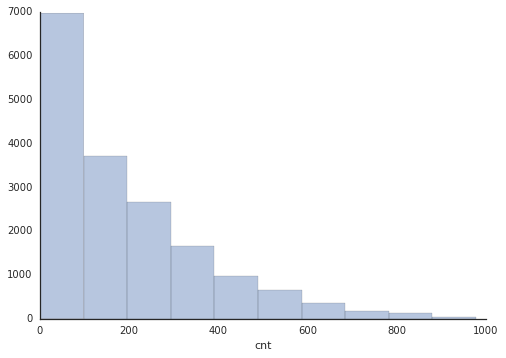

In [5]:
# review distribution of cnt in histogram
ax = sns.distplot(bike_rentals['cnt'], bins=10, kde=False)
sns.despine()

From the above histogram, we can see that low counts of bike rentals are the most common.  Larger counts of bike rentals on a given day occur less frequently.

We can also review the features in our data to determine which are correlated with our target variable `cnt`.  Let's develop the correlation matrix.  We can also better view the correlations using a heatmap.

In [6]:
# drop columns we will not be using (index, date, and the breakdowns of cnt)
bike_rentals = bike_rentals.drop(['instant', 'dteday', 'casual', 'registered'], axis=1)

In [7]:
# calculate correlations of numeric columns with cnt
corr_with_cnt = bike_rentals.corr()['cnt'].sort_values(ascending=False)
corr_with_cnt

cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

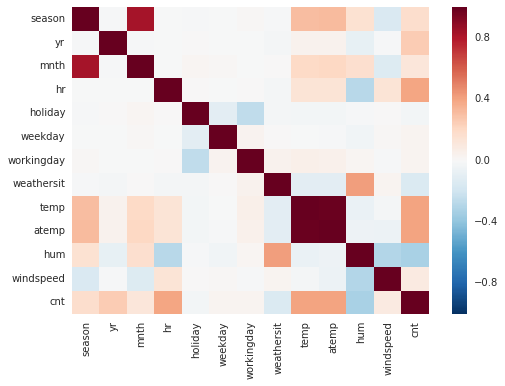

In [8]:
# create a correlation heatmap of the numerical features
corr_matrix = bike_rentals.corr()
sns.heatmap(corr_matrix)

While it does not appear that any of the features are strongly correlated with `cnt`, there are some features that are highly correlated to each other.

Specifically, `mnth` appears to be highly correlated with `season`.  This makes sense, as both of these features are dependent on the calendar.  While they may be highly correlated, the months do not exactly line up with the seasons, as some months will have days in two seasons.

Another example is `temp` and `atemp`.  The adjusted temperature is how warm or cold it actually feels.  This is definitely going to be highly correlated with the temperatue.

We can look more closely at how correlated these features are by looking at the actual values in the correlation matrix.  If features are too strongly correlated, we may need to remove them before modeling.

In [9]:
# review some of the features with strongest correlations
corr_matrix[['mnth', 'temp']]

,mnth,temp
season,0.830386,0.312025
yr,-0.010473,0.040913
mnth,1.000000,0.201691
hr,-0.005772,0.137603
holiday,0.018430,-0.027340
weekday,0.010400,-0.001795
workingday,-0.003477,0.055390
weathersit,0.005400,-0.102640
temp,0.201691,1.000000
atemp,0.208096,0.987672


The features `mnth` and `season` have a correlation of 0.83. `temp` and `atemp` are extremely highly correlated at 0.99.  If we are performing linear regressions, we do not want to include highly correlated features to avoid issues with multicollinearity.  These high correlations may also be a problem with decision tree models, as they can be very sensitive to small changes in the training data.  Random forest models, however, are robust to correlated variables.

## Creating New Features

Let's create a new feature for time of day to group the `hr` feature.  This will provide some order and relation between the hours by bundling similar hours together.

We can create the following:
- 1: morning (`hr` from 6 to 12)
- 2: afternoon (`hr` from 12 to 18)
- 3: evening (`hr` from 18 to 24)
- 4: night (`hr` from 0 to 6)

In [10]:
# create function to assign label for time of day based on hour
def create_label(hour):
    if hour < 6:
        return 4
    elif hour < 12:
        return 1
    elif hour < 18:
        return 2
    else:
        return 3

In [11]:
# apply the function to hour to create time_of_day
bike_rentals['time_of_day'] = bike_rentals['hr'].apply(create_label)
bike_rentals['time_of_day'].value_counts()

2    4375
3    4368
1    4360
4    4276
Name: time_of_day, dtype: int64

## Error Metric

To evaluate our models, we will need to choose an error metric.  Root mean squared error (RMSE) makes the most sense, as it works for continuous, numerical data.  It punishes large errors (due to the squaring).  Using the RMSE, rather than just MSE, our error metric will be in understandable units (rather than squared units).

## Train and Test Data

Now let's split our data into training data and testing data.  We will use an 80/20 split for the data.

In [12]:
# select a random sample of 80% of the data for train
train = bike_rentals.sample(frac=0.80, random_state=1)

In [13]:
# the remainder of our data will be assigned to test
test = bike_rentals.loc[~bike_rentals.index.isin(train.index)]

## Modeling

Now we can begin to evaluate different models for our data.  We can consider a linear regression model, a decision tree, and a random forest.

In [14]:
# imports for modeling
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [15]:
# create full features and trimmed features columns lists
full_features = bike_rentals.columns.drop(['cnt'])
trim_features = full_features.drop(['atemp', 'season', 'time_of_day'])
# create target
target = ['cnt']

### Linear Regression

The first model we will investigate is linear regression.  We will train the model on the train subset of data and evaluate its performance on the test subset using the RMSE metric.  We can look at the performance using all of the features (full_features) as well as a trimmed down list of features (trim_features) that removes some features that are highly correlated.

In [16]:
# linear regression model - full_features
reg_full = LinearRegression()
reg_full.fit(train[full_features], train[target])
predictions_reg_full = reg_full.predict(test[full_features])
rmse_reg_full = np.sqrt(mean_squared_error(test[target], predictions_reg_full))
rmse_reg_full

130.5946379586095

In [17]:
# linear regression model - trim_features
reg_trim = LinearRegression()
reg_trim.fit(train[trim_features], train[target])
predictions_reg_trim = reg_trim.predict(test[trim_features])
rmse_reg_trim = np.sqrt(mean_squared_error(test[target], predictions_reg_trim))
rmse_reg_trim

140.48506359704018

The RMSE is very high, given that the average `cnt` is about 189.  There are very few high rental count observations, and these may be causing higher errors.

### Decision Tree

The next model to investigate is the decision tree.  Since this model can tend to overfit, we will want to experiment with different parameters for the model.

In [18]:
# initial decision tree model
tree = DecisionTreeRegressor(random_state=1)
tree.fit(train[full_features], train[target])
predictions_tree = tree.predict(test[full_features])
rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
rmse_tree

57.97565806011068

This is a dramatic improvement in the RMSE metric!  Let's look at how the RMSE changes as we change different parameters of the model.

In [19]:
# decision tree with min_samples_split
rmse_min_samples_split = {}
min_samples = [2, 5, 10, 15, 19, 20, 21, 25, 30]
for i in min_samples:
    tree = DecisionTreeRegressor(random_state=1, min_samples_split=i)
    tree.fit(train[full_features], train[target])
    predictions_tree = tree.predict(test[full_features])
    rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
    rmse_min_samples_split[i] = rmse_tree
best_rmse = sorted(rmse_min_samples_split.items(), key=lambda x: x[0])
best_rmse

[(2, 57.97565806011068),
 (5, 56.997213191917815),
 (10, 56.19078990059445),
 (15, 55.719288465901236),
 (19, 54.60297531998544),
 (20, 54.313162075195166),
 (21, 54.36780553619447),
 (25, 54.573509341155976),
 (30, 55.15049154117209)]

We can improve our model by selecting a min_samples_split of 20.  Let's look at a few other possible parameters.

In [20]:
# decision tree with min_samples_leaf
rmse_min_samples_leaf = {}
for i in range(2,16):
    tree = DecisionTreeRegressor(random_state=1, min_samples_leaf=i)
    tree.fit(train[full_features], train[target])
    predictions_tree = tree.predict(test[full_features])
    rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
    rmse_min_samples_leaf[i] = rmse_tree
best_rmse = sorted(rmse_min_samples_leaf.items(), key=lambda x: x[0])
best_rmse

[(2, 55.59598927568774),
 (3, 55.89001382245454),
 (4, 55.16303948153995),
 (5, 55.05035825499082),
 (6, 54.17769259278429),
 (7, 53.7507355557973),
 (8, 53.78616690331471),
 (9, 54.02273704283459),
 (10, 54.32212883787292),
 (11, 54.60780814059192),
 (12, 54.96747222160683),
 (13, 54.54490934443157),
 (14, 55.31462834286756),
 (15, 56.95157268280956)]

We can also improve our model by selecting a min_samples_leaf of 7.  Let's look at a few other possible parameters.

In [21]:
# decision tree with max_depth
rmse_max_depth = {}
max_depth = [10, 20, 30, 40, 50]
for i in max_depth:
    tree = DecisionTreeRegressor(random_state=1, max_depth=i)
    tree.fit(train[full_features], train[target])
    predictions_tree = tree.predict(test[full_features])
    rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
    rmse_max_depth[i] = rmse_tree
best_rmse = sorted(rmse_max_depth.items(), key=lambda x: x[0])
best_rmse

[(10, 60.840960731021426),
 (20, 58.36418174897915),
 (30, 58.015912364254405),
 (40, 57.97565806011068),
 (50, 57.97565806011068)]

This parameter does not help us reduce our error metric.

In [22]:
# decision tree with max_features
rmse_max_features = {}
for i in range(4,14):
    tree = DecisionTreeRegressor(random_state=1, max_features=i)
    tree.fit(train[full_features], train[target])
    predictions_tree = tree.predict(test[full_features])
    rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
    rmse_max_features[i] = rmse_tree
best_rmse = sorted(rmse_max_features.items(), key=lambda x: x[0])
best_rmse

[(4, 86.50469266290851),
 (5, 69.83847311752886),
 (6, 66.62582945636014),
 (7, 61.56085895746686),
 (8, 64.38070754078619),
 (9, 63.44899322354692),
 (10, 61.026230471196484),
 (11, 60.39386750222012),
 (12, 59.9406387884375),
 (13, 57.97565806011068)]

This metric also does not help us reduce our error metric.  Note that removing any of the features will not improve our model, so we can use full_features rather than trim_features.

The best option of the parameters above was min_samples_leaf of 7, where we obtained a RMSE of 53.7507355557973.  However, min_samples_split also helped to reduce our error.  Can we combine these two parameters to do any better? 

In [23]:
# decision tree with min_samples_leaf of 7 and min_samples_split
rmse_min_samples_combined = {}
for i in range(15,25):
    tree = DecisionTreeRegressor(random_state=1, min_samples_leaf=7, 
                                 min_samples_split=i)
    tree.fit(train[full_features], train[target])
    predictions_tree = tree.predict(test[full_features])
    rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
    rmse_min_samples_combined[i] = rmse_tree
best_rmse = sorted(rmse_min_samples_combined.items(), key=lambda x: x[0])
best_rmse

[(15, 53.79422569212631),
 (16, 54.02228622149228),
 (17, 53.98082297752051),
 (18, 53.65105390261412),
 (19, 53.48434806203951),
 (20, 53.463535169583814),
 (21, 53.72239100886752),
 (22, 53.67445271178587),
 (23, 53.991758358203874),
 (24, 53.938468255320494)]

If we use min_samples_leaf of 7 and min_samples_split of 20, our RMSE gets down to 53.463535169583814.  By limiting the minimum number of samples required to be at a leaf node and limiting the number of samples required to split an internal node, we can reduce the overfitting of the model.

In [24]:
# resulting decision tree model
tree = DecisionTreeRegressor(random_state=1, min_samples_leaf=7, 
                             min_samples_split=20)
tree.fit(train[full_features], train[target])
predictions_tree = tree.predict(test[full_features])
rmse_tree = np.sqrt(mean_squared_error(test[target], predictions_tree))
rmse_tree

53.463535169583814

### Random Forest Model

The next model to investigate is the random forest model.  We will also want to investigate the parameters for this model, similar to what we did for the decision tree model.

In [25]:
# initial random forest model
forest = RandomForestRegressor(random_state=1)
forest.fit(train[full_features], train['cnt'])
predictions_forest = forest.predict(test[full_features])
rmse_forest = np.sqrt(mean_squared_error(test['cnt'], predictions_forest))
rmse_forest

46.410854139612844

The random forest model has improved even more over the decision tree model!  Let's investigate the various parameters to see if this can be improved.

In [26]:
# random forest with min_samples_split
rmse_min_samples_split = {}
for i in range(2, 11):
    forest = RandomForestRegressor(random_state=1, min_samples_split=i)
    forest.fit(train[full_features], train['cnt'])
    predictions_forest = forest.predict(test[full_features])
    rmse_forest = np.sqrt(mean_squared_error(test['cnt'], predictions_forest))
    rmse_min_samples_split[i] = rmse_forest
best_rmse = sorted(rmse_min_samples_split.items(), key=lambda x: x[0])
best_rmse

[(2, 46.410854139612844),
 (3, 46.26999125273833),
 (4, 46.48561594576344),
 (5, 46.19711762106733),
 (6, 46.345604229814036),
 (7, 46.07129911180877),
 (8, 46.20043856815267),
 (9, 46.24524018973908),
 (10, 46.53877101254192)]

We can improve upon the initial model by using min_samples_split of 7.  Let's also look at min_samples_leaf.

In [27]:
# random forest with min_samples_leaf
rmse_min_samples_leaf = {}
for i in range(1, 7):
    forest = RandomForestRegressor(random_state=1, min_samples_leaf=i)
    forest.fit(train[full_features], train['cnt'])
    predictions_forest = forest.predict(test[full_features])
    rmse_forest = np.sqrt(mean_squared_error(test['cnt'], predictions_forest))
    rmse_min_samples_leaf[i] = rmse_forest
best_rmse = sorted(rmse_min_samples_leaf.items(), key=lambda x: x[0])
best_rmse

[(1, 46.410854139612844),
 (2, 45.38966197968034),
 (3, 46.10076678151248),
 (4, 46.89796536941684),
 (5, 47.9265012702772),
 (6, 48.48029103122137)]

We can improve even more by setting min_samples_leaf to 2 (rather than allowing it to go to 1).  Let's see if we can improve this even further by combining min_samples_leaf and min_samples_split.

In [28]:
# random forest with min_samples_leaf = 2 and min_samples_split
rmse_min_samples_combined = {}
for i in range(2, 11):
    forest = RandomForestRegressor(random_state=1, min_samples_leaf=2, 
                                   min_samples_split=i)
    forest.fit(train[full_features], train['cnt'])
    predictions_forest = forest.predict(test[full_features])
    rmse_forest = np.sqrt(mean_squared_error(test['cnt'], predictions_forest))
    rmse_min_samples_combined[i] = rmse_forest
best_rmse = sorted(rmse_min_samples_combined.items(), key=lambda x: x[0])
best_rmse

[(2, 45.38966197968034),
 (3, 45.38966197968034),
 (4, 45.38966197968034),
 (5, 45.414912453515356),
 (6, 45.63293858216443),
 (7, 45.55807381778391),
 (8, 45.931893075268846),
 (9, 46.164557017340734),
 (10, 46.38386619832955)]

We don't do any better this time by combining the two parameters.  45.38966197968034 was still the minimum RMSE.  By setting min_samples_leaf, we reduce the overfitting of the model.

In [29]:
# resulting random forest model
forest = RandomForestRegressor(random_state=1, min_samples_leaf=2)
forest.fit(train[full_features], train['cnt'])
predictions_forest = forest.predict(test[full_features])
rmse_forest = np.sqrt(mean_squared_error(test['cnt'], predictions_forest))
rmse_forest

45.38966197968034

Overall, we see that the decision tree model was able to significantly improve over the linear regression model.  The random forest was able to improve even further over the decision tree model.  In addition, by modifying some of the parameters, we reduced the overfitting of the model and improved the accuracy.